# Loss Functions

sMAPE appears to perform far better than MAPE (as compared on CNN Conv1D LSTM on 1000epochs)

However this beavior is not consistent over 3 stocks

# CNN Conv1D LSTM

This model appears to perform shit on apple

## Getting the best hyperparameters for a set of stocks

In [1]:
from keras_tuner import Hyperband
from OptimizeNN_keras import MP_CNN_Bi_Dir_LSTM

import json
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
%load_ext autoreload
%autoreload 2
from Raw_Data import *
#Setting up GPU computation 
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

os.environ["RUNFILES_DIR"] = "/Library/Frameworks/Python.framework/Versions/3.7/share/plaidml"
# plaidml might exist in different location. Look for "/usr/local/share/plaidml" and replace in above path

os.environ["PLAIDML_NATIVE_PATH"] = "/Library/Frameworks/Python.framework/Versions/3.7/lib/libplaidml.dylib"
# libplaidml.dylib might exist in different location. Look for "/usr/local/lib/libplaidml.dylib" and replace in above path


stocks = ['NOK'] 

for stock in stocks:
    #try,
    #TODO: Write something that detects flat phase of stock and selects date to exclude phase
    data = get_data(stock)
    x_data, x_days, y_data, y_days=format_data_2(data, input_length=50, input_quantfiers=['close'], output_length=1,offset=5, output_quantifiers=['close'], sliding_window = False, scaling_func = None)
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42) #FIXME: Dont randomize data!
    #Finding the best set of parameters and writing it to a file
    tuner = Hyperband(
        hypermodel = MP_CNN_Bi_Dir_LSTM, #TODO: CHeck with BatchNormalization rather than Layer
        max_epochs=100, #TODO: set this to a value slightly higher than the expected epochs to convergence for your largest Mode
        objective="MAPE", #TODO: Change MAPE to something more descriptive, changed loss but also metric?
        factor=3,
        hyperband_iterations=3, #In my interest to set as high as possible, max_epochs * (math.log(max_epochs, factor) ** 2)  one iteration runs prior nr of epochs across trials
        directory='Optimizer',
        project_name= 'MP_CNN_Bi_Dir_LSTM_First_try_{}'.format(stock),
        overwrite=True
        )
    tuner.search(X_train, y_train,
                validation_data=(X_test, y_test),
                callbacks=[TensorBoard("./tb_logs/{}_{}".format(stock, 'MP_CNN_Bi_Dir_LSTM'))])
    print('Completed Search')
    #Saving best parameters
    with open('hyperparameter_best/params','r+') as file:
        try:
            file_data = json.load(file)
        except:
            file_data = {}
        file_data.update({'{}_{}'.format(stock,'MP_CNN_Bi_Dir_LSTM'):tuner.get_best_hyperparameters()[0].get_config()['values']})
    json.dump(file_data,file,indent=4)
    print('Saved hyperparameters')
    print(file_data)
'''
    except Exception as e:
        print('Couln`t compute for ', stock)
        print('Due to: ', e)'''

Trial 10 Complete [00h 00m 27s]
MAPE: 99.43426513671875

Best MAPE So Far: 95.49618530273438
Total elapsed time: 00h 04m 42s

Search: Running Trial #11

Hyperparameter    |Value             |Best Value So Far 
kernel 1          |9                 |9                 
alpha1            |0                 |0.22              
kernel 2          |9                 |9                 
alpha2            |0.66              |0.66              
kernel 3          |5                 |5                 
alpha3            |0.77              |0.99              
learning rate     |0.01              |0.1               
rho               |0.15              |0.2               
epsilon           |0.0001            |0.001             
tuner/epochs      |2                 |2                 
tuner/initial_e...|0                 |0                 
tuner/bracket     |4                 |4                 
tuner/round       |0                 |0                 



# Using best parameters

In [10]:
from keras_tuner import Hyperband
from OptimizeNN_keras import CNN_UNIV_10
from Raw_Data import format_data_2, get_data
from NeuralNetwork import get_data_CNN_UNIV_10

import plaidml.keras
import os
plaidml.keras.install_backend()
os.environ['KERAS_BACKEND'] = 'plaidml.keras.backend'

data = get_data('NOK')
x_data, x_days, y_data, y_days =format_data_2(data, input_length=10, input_quantfiers=['close'], output_length=5,offset=5, output_quantifiers=['close'], sliding_window = False, scaling_func = None)

tuner = Hyperband(
            hypermodel = CNN_UNIV_10,
            max_epochs=100, #TODO: set this to a value slightly higher than the expected epochs to convergence for your largest Mode
            objective="MAPE", 
            factor=3,
            hyperband_iterations=1, #In my interest to set as high as possible, max_epochs * (math.log(max_epochs, factor) ** 2)  one iteration runs prior nr of epochs across trials
            directory='Optimizer',
            project_name= 'CNN_UNIV_10_av_{}'.format('NOK'),
            overwrite=True
            )

tuner.search(x_data, y_data,
                    validation_split=0.2,verbose=1,shuffle=False,batch_size=32)

Trial 100 Complete [00h 00m 01s]
MAPE: 86.61383056640625

Best MAPE So Far: 80.7489013671875
Total elapsed time: 00h 03m 37s

Search: Running Trial #101

Hyperparameter    |Value             |Best Value So Far 
conv1             |4                 |88                
alpha1            |0.4               |0.2               
MaxPool1          |4                 |8                 
dense1            |25                |40                
alpha2            |0.2               |0.3               
alpha3            |0.1               |0.2               
learning rate     |0.01              |0.01              
tuner/epochs      |4                 |2                 
tuner/initial_e...|2                 |0                 
tuner/bracket     |4                 |4                 
tuner/round       |1                 |0                 
tuner/trial_id    |23cc353f25bf62a...|None              

Epoch 3/4


KeyboardInterrupt: 

In [2]:
from tensorflow.keras.callbacks import EarlyStopping
from OptimizeNN_keras import CNN_UNIV_10
from Raw_Data import format_data_2, get_data
from keras_tuner import HyperParameters

data = get_data('NOK')
x_data, x_days, y_data, y_days =format_data_2(data, input_length=10, input_quantfiers=['close'], output_length=1,offset=1, output_quantifiers=['close'], sliding_window = False)
x_data, x_days, y_data, y_days = x_data[-len(x_data)//3::], x_days, y_data[-len(x_data)//3::], y_days

hp = HyperParameters()
hp.Fixed("conv1", 88)
hp.Fixed("alpha1", 0.4)
hp.Fixed("MaxPool1", 4)
hp.Fixed("dense1", 55)
hp.Fixed("alpha2", 0.4)
hp.Fixed("alpha3", 0.6)
hp.Fixed("learning rate", 0.01)

callback = EarlyStopping(monitor='loss', patience=5)

model = CNN_UNIV_10(hp)

model.fit(x_data,y_data,validation_split=0.2,epochs=1000,shuffle=False,batch_size=32,callbacks=[callback])

Epoch 1/1000
4/4 [==============================] - 2s 132ms/step - loss: 1.3861 - MAPE: 79.3364 - val_loss: 1.0505 - val_MAPE: 226.8186
Epoch 2/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.5431 - MAPE: 54.7397 - val_loss: 1.6525 - val_MAPE: 972.6492
Epoch 3/1000
4/4 [==============================] - 0s 27ms/step - loss: 0.5457 - MAPE: 89.5454 - val_loss: 1.7402 - val_MAPE: 1369.9585
Epoch 4/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.5474 - MAPE: 93.6166 - val_loss: 1.6736 - val_MAPE: 1049.4248
Epoch 5/1000
4/4 [==============================] - 0s 27ms/step - loss: 0.4672 - MAPE: 66.7218 - val_loss: 1.4608 - val_MAPE: 555.4602
Epoch 6/1000
4/4 [==============================] - 0s 28ms/step - loss: 0.3469 - MAPE: 37.9228 - val_loss: 1.1089 - val_MAPE: 256.0670
Epoch 7/1000
4/4 [==============================] - 0s 44ms/step - loss: 0.3312 - MAPE: 29.4227 - val_loss: 1.0572 - val_MAPE: 231.0423
Epoch 8/1000
4/4 [===========================

In [2]:
from keras_tuner import Hyperband
from OptimizeNN_keras import CNN_Conv1D_LSTM_sMAPE
tuner = Hyperband(
    hypermodel = CNN_Conv1D_LSTM_sMAPE,
    max_epochs=1000, #TODO: set this to a value slightly higher than the expected epochs to convergence for your largest Mode
    objective="MAPE", #TODO: Change MAPE to something more descriptive, changed loss but also metric?
    factor=5,
    hyperband_iterations=2, #In my interest to set as high as possible, max_epochs * (math.log(max_epochs, factor) ** 2)  one iteration runs prior nr of epochs across trials
    directory='Optimizer',
    project_name= 'CNN_Conv1D_LSTM_{}'.format('NOK')
    )
tuner.reload()

INFO:tensorflow:Reloading Oracle from existing project Optimizer/CNN_Conv1D_LSTM_NOK/oracle.json
INFO:tensorflow:Reloading Tuner from Optimizer/CNN_Conv1D_LSTM_NOK/tuner0.json


In [21]:
models = tuner.get_best_models(num_models=3)
params= tuner.get_best_hyperparameters(num_trials=3)
from Raw_Data import *
data = get_data('NOK')
x_data, x_days, y_data, y_days =format_data_2(data, input_length=10, input_quantfiers=['close'], output_length=1,offset=1, output_quantifiers=['close'], sliding_window = False)
x_data, x_days, y_data, y_days = x_data[-len(x_data)//2::], x_days, y_data[-len(x_data)//2::], y_days

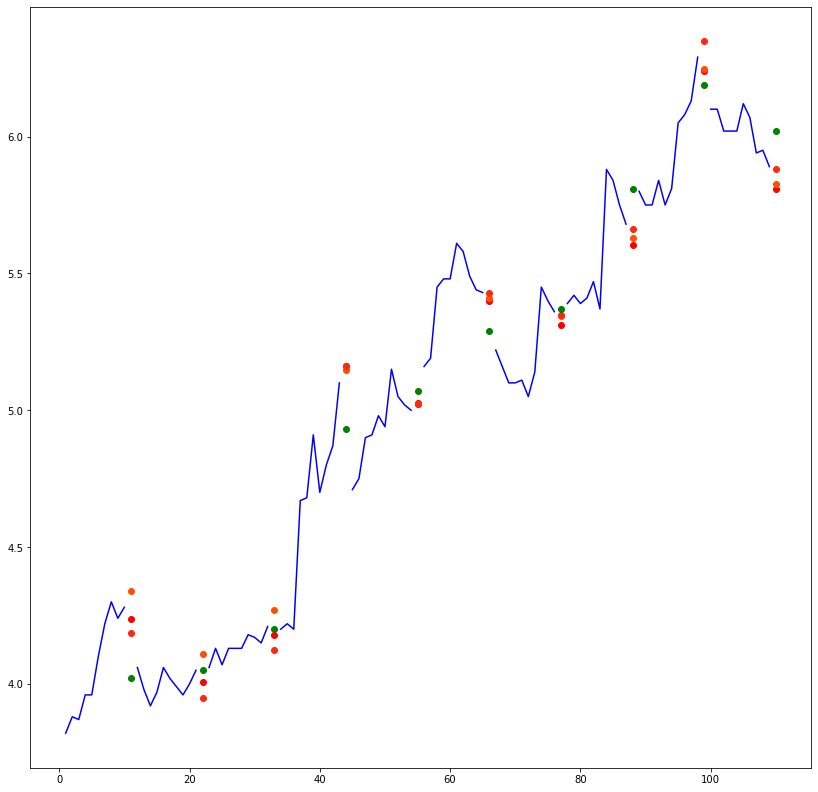

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14,14))
index = np.linspace(1,110,110)
count = 0
for i in x_data[-10:]:
    count2 = 0 
    for j in ['r','#ff5000','#ff2812']:
        y_pred=models[count2].predict(np.array([i]))
        count2+=1
        plt.scatter(index[10], y_pred,c=j,label='prediction')
    plt.plot(index[0:10],np.array(i).flatten(),c='b',label='Orig')
    plt.scatter(index[10], y_data[-10+count],c='g',label='actual')
    index = index[11:]
    count+=1



In [4]:
%matplotlib inline

<AxesSubplot:xlabel='Date'>

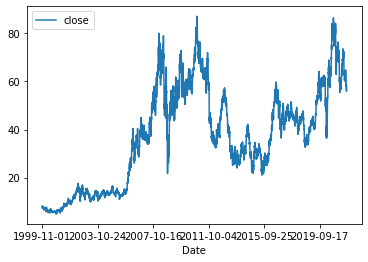

In [5]:
import pandas as pd
dat = pd.read_csv("stockdata/AEM.csv", parse_dates=True, sep=' ', names=['Date', 'open', 'high', 'low', 'close', 'volume'])
dat.plot(x='Date',y='close')

[array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])]


In [39]:
zeros = 0
count = 0
for i in res:
    if i == 0:
        zeros += 1
if zeros > 0:
    print('The model predicted {} zero values'.format(zeros))
if (int(0) in y_dat) or (float(0) in y_dat):
    index = np.where(y_dat==0)
    for i in index: #Delete all rows with 0 values #TODO: This should not be required, remove at some point
        count += 1
        y_dat = np.delete(y_dat, i)
        y_days_dat = np.delete(y_days_dat, i)
        x_dat = np.delete(x_dat, i, axis=0)
        x_days_dat = np.delete(x_days_dat, i, axis=0)
    print('Had to delete {} items from input data'.format(count))
if val:
    res = model_MAPE.predict(x_val)
    diff = abs(res.flatten()-y_val.flatten())/y_val.flatten()
    res1 = model_sMAPE.predict(x_val)
    diff1 = abs(res1.flatten()-y_val.flatten())/y_val.flatten()
else:
    res = model_MAPE.predict(x_dat)
    diff = abs(res.flatten()-y_dat.flatten())/y_dat.flatten()
    res1 = model_sMAPE.predict(x_dat)
    diff1 = abs(res1.flatten()-y_dat.flatten())/y_dat.flatten()


Had to delete 1 items from input data


<function matplotlib.pyplot.show(close=None, block=None)>

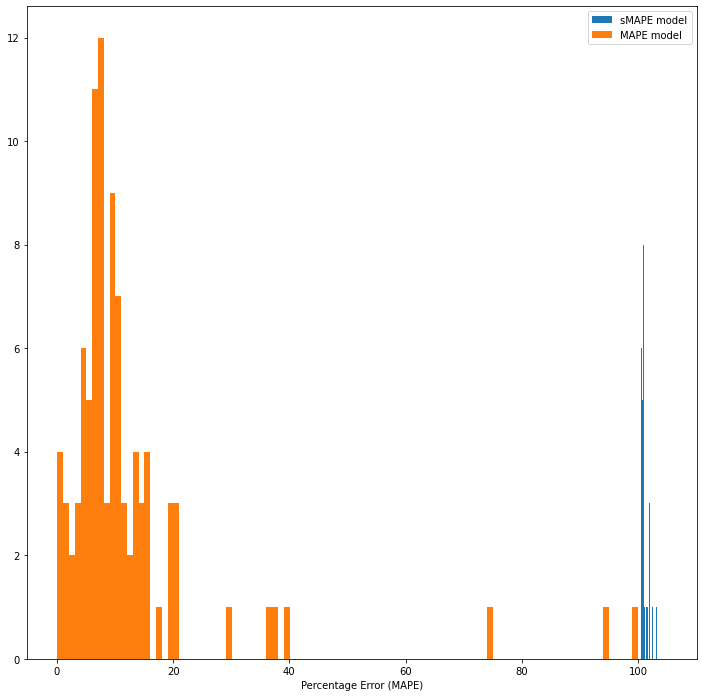

In [40]:
fig = plt.figure(figsize=(12,12))
plt.hist(diff*100,bins=100,label='sMAPE model')
plt.hist(diff1*100,bins=100,label='MAPE model')
plt.xlabel('Percentage Error (MAPE)')
plt.legend()
plt.show

ValueError: x and y must have same first dimension, but have shapes (96,) and (95, 1)

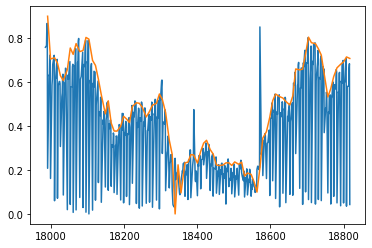

In [46]:
from matplotlib.dates import datestr2num
#x_days_dat = datestr2num(x_days_dat.flatten())
y_days_dat = datestr2num(y_days_dat)
plt.plot(x_days_dat,x_dat[::, 3].flatten())
plt.plot(y_days_dat,y_dat)
plt.plot(y_days_dat,res,label='MAPE') #FIXME: Thing predicts zeros again
plt.plot(y_days_dat,res1,label='sMAPE')

In [2]:
%load_ext autoreload
%autoreload 2
from Raw_Data import ModDataset
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
mod = ModDataset(os.path.abspath('../stockdata/NOK.csv'))

In [12]:
mod.prep_MultiLayerPerceptron(offset=100)

nr_peak/nr_troth =  0.9965156794425087
sum of buy (-1) and sell (+1)  -1.0
With sum difference:  541.1083999999997


In [23]:
mod.get_data_MLP()[0]

array([ -3.61186069,  31.71585584,  43.91092554, -76.47849462])

In [169]:
import numpy as np
y=mod.data['close'].to_numpy()
x=mod.data.index
buy = np.array([[i,y[i]]  for i in range(len(labels)) if labels[i]==-1]).transpose()
sell = np.array([[i,y[i]] for i in range(len(labels)) if labels[i]==1]).transpose()

(0.0, 1000.0)

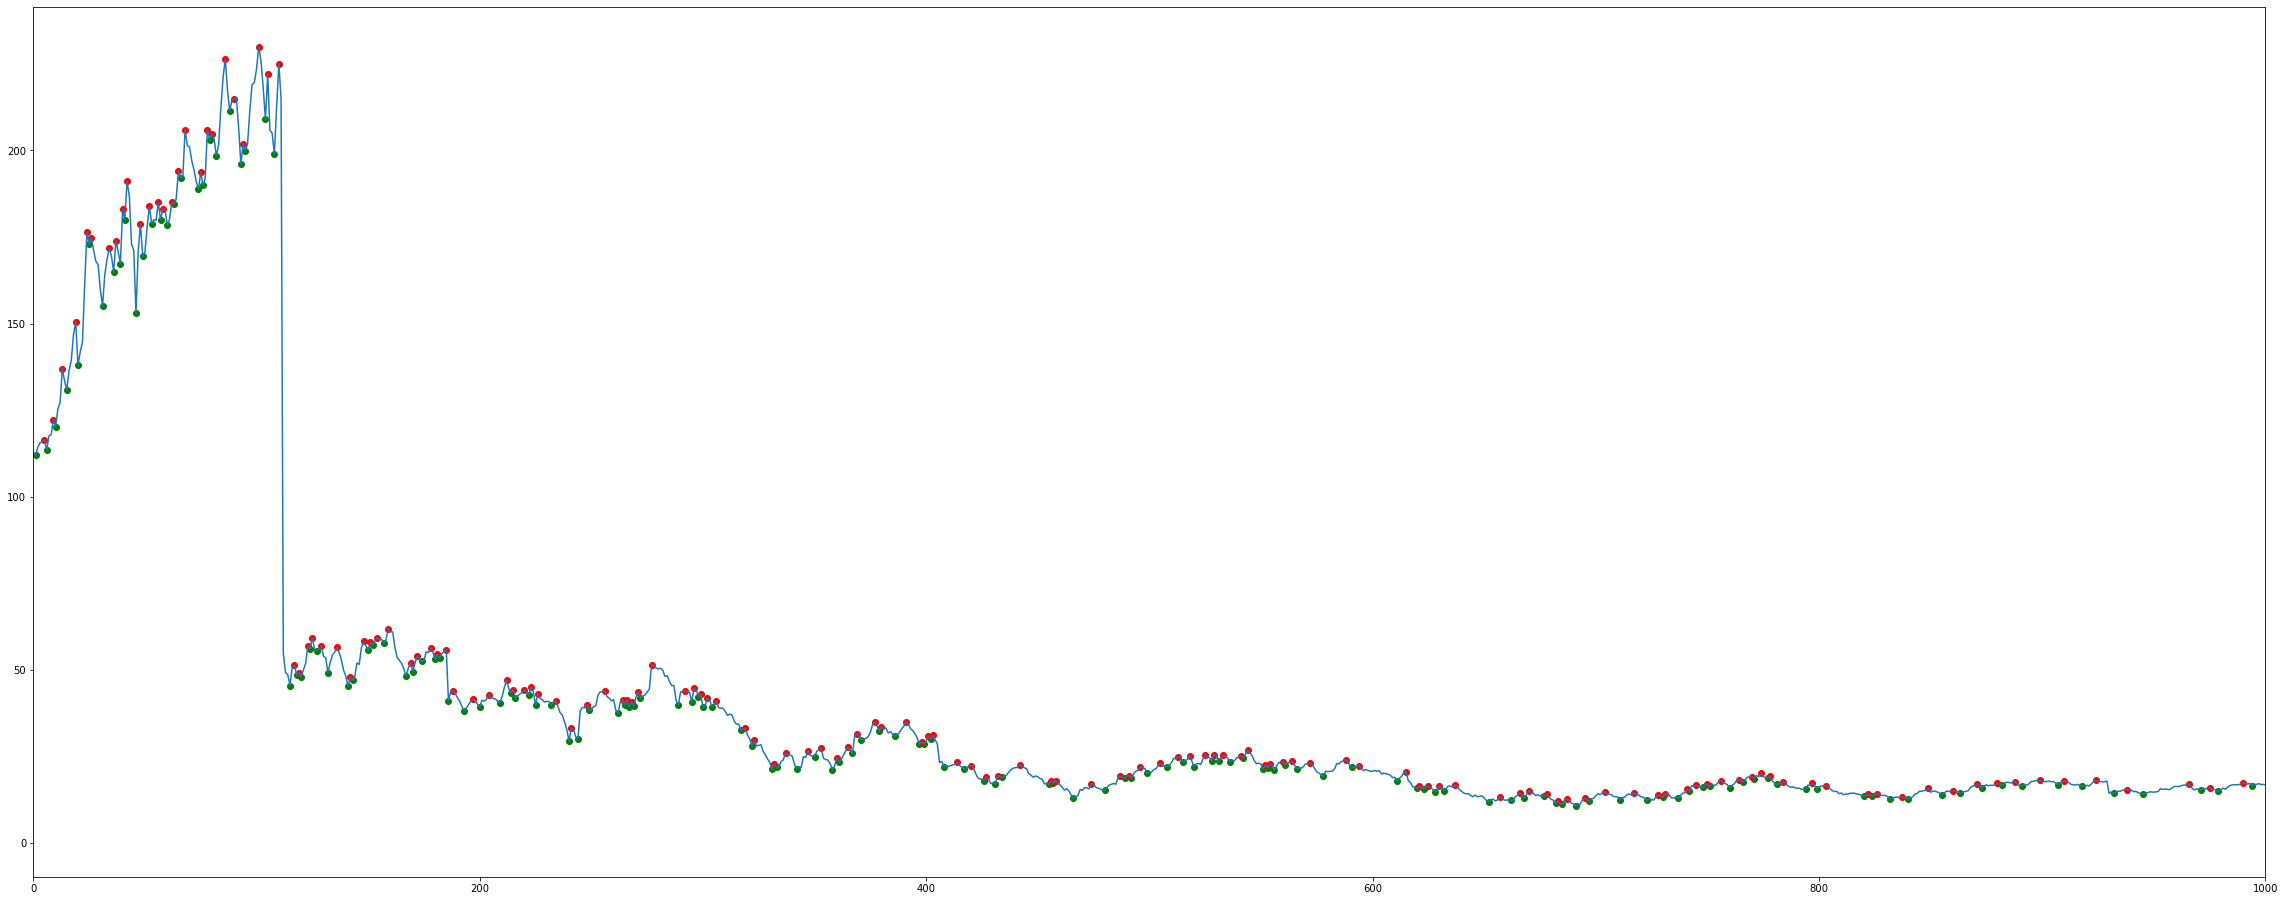

In [174]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(40,16))
plt.plot(x,y)
plt.scatter(buy[0],buy[1],c='g')
plt.scatter(sell[0],sell[1],c='r')
plt.xlim(0,1000)
#plt.ylim(0,50)

In [9]:
directorycsv = os.path.abspath('../stockdata/{}'.format(stock+'.csv'))
dataset = ModDataset(directorycsv)
dataset.data.iloc[::,::]

,Date,open,high,low,close,volume
0,1999-11-01,112.90,114.40,111.80,112.80,3619900
1,1999-11-02,111.70,115.00,111.50,112.00,2545800
2,1999-11-03,112.80,114.80,112.00,114.30,2490400
3,1999-11-04,114.90,116.60,113.90,115.60,2527600
4,1999-11-05,117.00,117.50,115.80,115.90,1755500
...,...,...,...,...,...,...
5483,2021-08-17,6.03,6.06,5.90,5.94,22006581
5484,2021-08-18,5.98,6.02,5.95,5.95,14948448
5485,2021-08-19,5.82,5.91,5.78,5.89,24224849
5486,2021-08-20,5.88,5.94,5.87,5.90,12266066


In [1]:
import numpy as np
from keras_tuner import HyperParameters
import os
%load_ext autoreload
%autoreload 2
from Raw_Data import ModDataset, append_pkl
from OptimizeNN_keras import MultiLayerPerceptron

In [5]:
from keras_tuner import Hyperband
from OptimizeNN_keras import MultiLayerPerceptron
from Raw_Data import ModDataset
import numpy as np

stock='NOK'
path = os.path.abspath('../stockdata_MLP')
x_train = np.loadtxt(os.path.join(path,'xtrain.csv'), dtype='int', delimiter=',', unpack=True).transpose()
y_train = np.loadtxt(os.path.join(path,'ytrain.csv'), dtype='int', delimiter=',', unpack=True).transpose()
x_test = np.loadtxt(os.path.join(path,'xtest.csv'), dtype='int', delimiter=',', unpack=True).transpose()
y_test = np.loadtxt(os.path.join(path,'ytest.csv'), dtype='int', delimiter=',', unpack=True).transpose()

print(len(x_train)+len(y_test))

tuner = Hyperband(
            hypermodel = MultiLayerPerceptron,
            max_epochs=50, #TODO: set this to a value slightly higher than the expected epochs to convergence for your largest Mode
            objective="accuracy", 
            factor=5,
            hyperband_iterations=1, #In my interest to set as high as possible, max_epochs * (math.log(max_epochs, factor) ** 2)  one iteration runs prior nr of epochs across trials
            directory=os.path.abspath('../Optimization/'),
            project_name= 'MultiLayerPerceptron_{}'.format(stock),
            overwrite=True
            )
tuner.search(x_train, y_train,validation_data=(x_test,y_test),epochs=20,verbose=1,batch_size=32,shuffle=True)

Trial 12 Complete [00h 00m 21s]
accuracy: 0.4541166424751282

Best accuracy So Far: 0.5403802394866943
Total elapsed time: 00h 02m 31s

Search: Running Trial #13

Hyperparameter    |Value             |Best Value So Far 
Dense1            |6                 |6                 
Dense2            |15                |5                 
Dense3            |4                 |8                 
learning rate     |0.15              |0.01              
epsilon           |0.0001            |0.001             
tuner/epochs      |2                 |2                 
tuner/initial_e...|0                 |0                 
tuner/bracket     |2                 |2                 
tuner/round       |0                 |0                 

Epoch 1/2
1312/1312 [==============================] - 7s 4ms/step - loss: 1.0592 - accuracy: 0.4281 - val_loss: 1.0227 - val_accuracy: 0.4912
Epoch 2/2
 590/1312 [============>.................] - ETA: 2s - loss: 1.0412 - accuracy: 0.4586

KeyboardInterrupt: 

In [23]:
from OptimizeNN_keras import MultiLayerPerceptron
from keras_tuner import HyperParameters

hp = HyperParameters()

hp.Fixed('Dense1', 6)
hp.Fixed('Dense1', 10)
hp.Fixed('Dense1', 6)
hp.Fixed('learning rate', 0.1)
hp.Fixed('epsilon', 1e-4)

model = MultiLayerPerceptron(hp)
model.fit(x_train, y_train,epochs=20,batch_size=20, validation_data=(x_test,y_test))

Epoch 1/20
495/495 [==============================] - 3s 4ms/step - loss: 0.9987 - accuracy: 0.4895 - val_loss: 0.8920 - val_accuracy: 0.6010
Epoch 2/20
495/495 [==============================] - 2s 3ms/step - loss: 0.9519 - accuracy: 0.5305 - val_loss: 0.8233 - val_accuracy: 0.6090
Epoch 3/20
495/495 [==============================] - 2s 3ms/step - loss: 0.9390 - accuracy: 0.5315 - val_loss: 0.8628 - val_accuracy: 0.6082
Epoch 4/20
495/495 [==============================] - 2s 4ms/step - loss: 0.9513 - accuracy: 0.5276 - val_loss: 0.8162 - val_accuracy: 0.6199
Epoch 5/20
495/495 [==============================] - 2s 3ms/step - loss: 0.9402 - accuracy: 0.5239 - val_loss: 0.8674 - val_accuracy: 0.6054
Epoch 6/20
495/495 [==============================] - 2s 3ms/step - loss: 0.9447 - accuracy: 0.5303 - val_loss: 0.8165 - val_accuracy: 0.6171
Epoch 7/20
495/495 [==============================] - 2s 3ms/step - loss: 0.9362 - accuracy: 0.5280 - val_loss: 0.8151 - val_accuracy: 0.6102
Epoch 

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt

labels = dataset.get_labels()[:-1000:]
data = dataset.get_data_MLP()[:-1000:]
delta = 0

prediction= model.predict(x_test)

decision=[np.where(prediction[i] == np.max(prediction[i])) for i in range(len(prediction))]


In [59]:
print(x_test)
res = [np.sum(i*[0,1,2]) for i in y_test]


[[  0.30336363  75.39091037  77.05882353 -15.31531532]
 [  0.84168986  74.10262716  72.91066282  -3.88349515]
 [ -0.10907432  56.3939744   58.28571429 -14.47527141]
 ...
 [ -0.2533351   63.08029307  58.39539759 -14.12693286]
 [  0.20263753  66.06858139  61.07356067 -10.64174504]
 [  0.17132029  82.42352054  76.45780628  -3.3580921 ]]


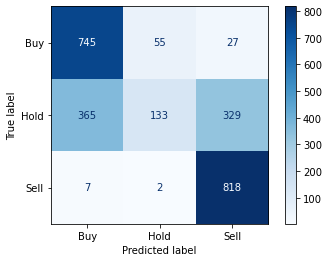

In [60]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

y_pred = np.array(np.array(decision).flatten())

y_test = np.array(res)

labels = ["Buy", "Hold", "Sell"]

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()


In [73]:
%load_ext autoreload
%autoreload 2
from Raw_Data import PatternBasedData

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
import os
stock='NOK'
directorycsv = os.path.abspath('../stockdata/{}'.format(stock+'.csv'))
data = PatternBasedData(directorycsv)
print(len(data.data.loc[::,'close']))
data.compute_patterns()

5488


In [94]:
display(data.data)

,Date,open,high,low,close,volume,candlestick_pattern,candlestick_match_count
0,1999-11-01,112.90,114.40,111.80,112.80,3619900,NO_PATTERN,0.0
1,1999-11-02,111.70,115.00,111.50,112.00,2545800,NO_PATTERN,0.0
2,1999-11-03,112.80,114.80,112.00,114.30,2490400,NO_PATTERN,0.0
3,1999-11-04,114.90,116.60,113.90,115.60,2527600,NO_PATTERN,0.0
4,1999-11-05,117.00,117.50,115.80,115.90,1755500,NO_PATTERN,0.0
...,...,...,...,...,...,...,...,...
5483,2021-08-17,6.03,6.06,5.90,5.94,22006581,NO_PATTERN,0.0
5484,2021-08-18,5.98,6.02,5.95,5.95,14948448,CDLHOMINGPIGEON_Bull,2.0
5485,2021-08-19,5.82,5.91,5.78,5.89,24224849,CDLHIKKAKE_Bull,1.0
5486,2021-08-20,5.88,5.94,5.87,5.90,12266066,NO_PATTERN,0.0


TypeError: object of type 'NoneType' has no len()

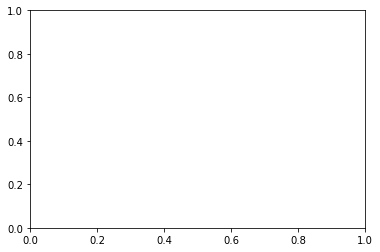

In [86]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(data.compute_patterns(),bins=50)